
# Laboratorio 7 - Simulación del Sistema de Torniquetes con SimPy (con NHPP)

Este cuaderno contiene:

1. Análisis de datos históricos de entradas y salidas del edificio Santo Domingo (SD).
2. Cálculo de tasas de llegadas y salidas por intervalos de 15 minutos.
3. Construcción del modelo base en SimPy con torniquetes y usuarios.
4. Generación de llegadas usando proceso de Poisson no homogéneo (NHPP) con tasas calculadas.


## Fase 1: Modelado de Llegadas y Salidas - Cálculo de tasas

Tipos de acceso detectados: ['IN' 'OUT']
Conteo por tipo de acceso:
TIPO_ACCESO
IN     608624
OUT    583713
Name: conteo, dtype: int64


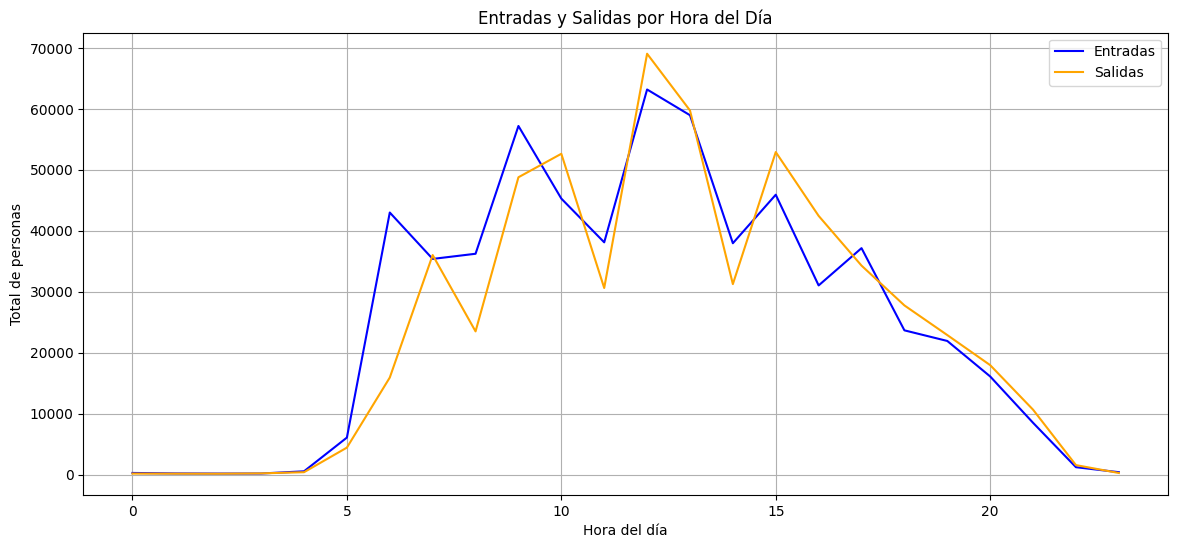

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Ruta de tu archivo
excel_path = 'SD Feb-May 2019.xlsx'

# Columnas que nos interesan
usecols = ['fecha_completa', 'MODO_ACCESO', 'TIPO_ACCESO']

def procesar_hoja_optimizada(sheet_name):
    df = pd.read_excel(excel_path, sheet_name=sheet_name, usecols=usecols, engine='openpyxl')
    df['fecha_completa'] = pd.to_datetime(df['fecha_completa'], errors='coerce')
    
    # Limpiar espacios en blanco y estandarizar
    df['TIPO_ACCESO'] = df['TIPO_ACCESO'].astype(str).str.strip().str.upper()
    df['MODO_ACCESO'] = df['MODO_ACCESO'].astype(str).str.strip().str.upper()
    
    # Filtrar entradas y salidas peatonales
    df = df[(df['MODO_ACCESO'] == 'PEATONAL') & (df['TIPO_ACCESO'].isin(['IN', 'OUT']))]
    
    df['intervalo_15min'] = df['fecha_completa'].dt.floor('15min')
    tasas = df.groupby(['intervalo_15min', 'TIPO_ACCESO']).size().reset_index(name='conteo')
    return tasas

# Procesar las dos hojas
tasas_feb_mar = procesar_hoja_optimizada('Feb-Mar')
tasas_abr_may = procesar_hoja_optimizada('Abr-May')

# Unir y consolidar
tasas_totales = pd.concat([tasas_feb_mar, tasas_abr_may])
tasas_totales = tasas_totales.groupby(['intervalo_15min', 'TIPO_ACCESO']).sum().reset_index()

# Validación de los tipos de acceso
print("Tipos de acceso detectados:", tasas_totales['TIPO_ACCESO'].unique())
print("Conteo por tipo de acceso:")
print(tasas_totales.groupby('TIPO_ACCESO')['conteo'].sum())

# Crear columna de hora
tasas_totales['hora'] = tasas_totales['intervalo_15min'].dt.hour

# Agrupar por hora y tipo de acceso
tasas_por_hora = tasas_totales.groupby(['hora', 'TIPO_ACCESO'])['conteo'].sum().reset_index()

# Pivotar para graficar
pivot = tasas_por_hora.pivot(index='hora', columns='TIPO_ACCESO', values='conteo').fillna(0)

# Graficar asegurando que ambas líneas aparezcan aunque sean cero
plt.figure(figsize=(14,6))
plt.plot(pivot.index, pivot.get('IN', pd.Series([0]*len(pivot))), label='Entradas', color='blue')
plt.plot(pivot.index, pivot.get('OUT', pd.Series([0]*len(pivot))), label='Salidas', color='orange')
plt.title('Entradas y Salidas por Hora del Día')
plt.xlabel('Hora del día')
plt.ylabel('Total de personas')
plt.legend()
plt.grid(True)
plt.show()


## Fase 2: Implementación de la Simulación en SimPy

In [5]:

import simpy
import random

TIEMPO_PREPARAR_CARNET = lambda: max(0, random.normalvariate(10, 2))
TIEMPO_LEER_QR = lambda: max(0, random.normalvariate(20, 2))
TIEMPO_TORNIQUETE = lambda: max(0, random.normalvariate(5, 2))

NUM_TORNIQUETES_ENTRADA = 3
NUM_TORNIQUETES_SALIDA = 3
NUM_QR_ENTRADA = 1
NUM_QR_SALIDA = 1

def inicializar_torniquetes(env):
    torniquetes_entrada = simpy.Resource(env, NUM_TORNIQUETES_ENTRADA)
    torniquetes_salida = simpy.Resource(env, NUM_TORNIQUETES_SALIDA)
    torniquetes_qr_entrada = simpy.Resource(env, NUM_QR_ENTRADA)
    torniquetes_qr_salida = simpy.Resource(env, NUM_QR_SALIDA)
    return torniquetes_entrada, torniquetes_salida, torniquetes_qr_entrada, torniquetes_qr_salida

def persona(env, id_persona, tipo_acceso, usa_qr, torniquetes):
    yield env.timeout(TIEMPO_PREPARAR_CARNET())
    if usa_qr:
        yield env.timeout(TIEMPO_LEER_QR())
        recurso = torniquetes[2] if tipo_acceso == 'IN' else torniquetes[3]
    else:
        recurso = torniquetes[0] if tipo_acceso == 'IN' else torniquetes[1]
    with recurso.request() as req:
        yield req
        yield env.timeout(TIEMPO_TORNIQUETE())


## Fase 3: NHPP y escenarios de crecimiento del 28%

In [6]:

import numpy as np

def generar_llegadas_nhpp(env, tasas, tipo_acceso, torniquetes):
    tasas_filtradas = tasas[tasas['TIPO_ACCESO'] == tipo_acceso]
    tasas_filtradas = tasas_filtradas.sort_values('intervalo_15min')
    for idx, row in tasas_filtradas.iterrows():
        tasa_por_minuto = row['conteo'] / 15.0
        inicio_intervalo = (row['intervalo_15min'].hour * 60 + row['intervalo_15min'].minute)
        tiempo_actual = inicio_intervalo
        while tiempo_actual < inicio_intervalo + 15:
            if tasa_por_minuto > 0:
                inter_arrival = np.random.exponential(1 / tasa_por_minuto)
                yield env.timeout(inter_arrival)
                tiempo_actual += inter_arrival
                if tiempo_actual >= inicio_intervalo + 15:
                    break
                env.process(persona(env, f"{tipo_acceso}_{idx}_{tiempo_actual}", tipo_acceso, random.random() < 0.1, torniquetes))
            else:
                break

def simular_nhpp(tasas):
    env = simpy.Environment()
    torniquetes = inicializar_torniquetes(env)
    env.process(generar_llegadas_nhpp(env, tasas, 'IN', torniquetes))
    env.process(generar_llegadas_nhpp(env, tasas, 'OUT', torniquetes))
    env.run(until=1440)

simular_nhpp(tasas_totales)


## Visualización de resultados

You should consider upgrading via the 'c:\Users\MarianaLozano\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


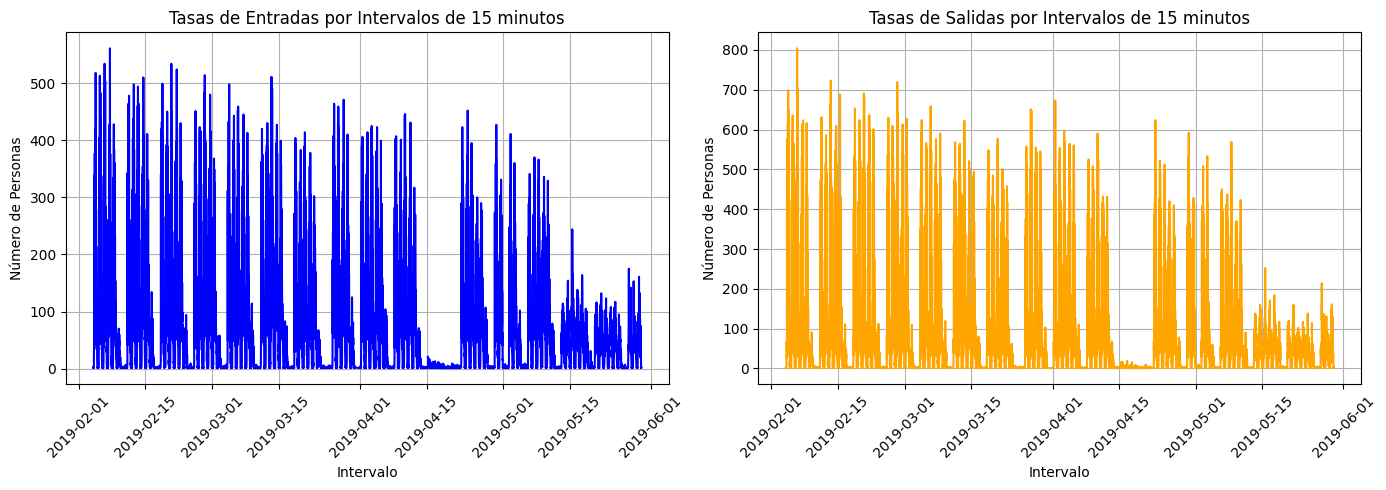

In [9]:

%pip install seaborn

import matplotlib.pyplot as plt
import seaborn as sns

# Crear dos gráficos separados
plt.figure(figsize=(14,5))

# Gráfico de Entradas
plt.subplot(1, 2, 1)
sns.lineplot(data=tasas_totales[tasas_totales['TIPO_ACCESO'] == 'IN'], x='intervalo_15min', y='conteo', color='blue')
plt.xticks(rotation=45)
plt.title('Tasas de Entradas por Intervalos de 15 minutos')
plt.xlabel('Intervalo')
plt.ylabel('Número de Personas')
plt.grid(True)

# Gráfico de Salidas
plt.subplot(1, 2, 2)
sns.lineplot(data=tasas_totales[tasas_totales['TIPO_ACCESO'] == 'OUT'], x='intervalo_15min', y='conteo', color='orange')
plt.xticks(rotation=45)
plt.title('Tasas de Salidas por Intervalos de 15 minutos')
plt.xlabel('Intervalo')
plt.ylabel('Número de Personas')
plt.grid(True)

plt.tight_layout()
plt.show()
